In [ ]:
import os, logging, itertools
from pathlib import Path
from dotenv import load_dotenv
from tqdm import tqdm

from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings
# Fallback: from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [ ]:
PDF_DIR           = "/home/gui/rag-knowledge-managment/docs/pdfs"        # folder with many PDFs
PERSIST_DIR       = "./chroma_db"   # where Chroma stores the collection
COLLECTION_NAME   = "my-rag"
CHUNK_SIZE        = 1000
CHUNK_OVERLAP     = 150
TOP_K             = 3              # how many chunks to retrieve
LLM_MODEL_NAME    = "llama-3.3-70b-versatile"

### Carrega os pdfs do diretorio

In [ ]:
def load_documents(pdf_dir):
    """Carrega os PDFs do diretório."""
    loader = PyPDFDirectoryLoader(pdf_dir, recursive=True)
    docs = loader.load()
    logging.info("Loaded %d pages from %s", len(docs), pdf_dir)
    return docs

### Divide os chunks dos arquivos

In [ ]:
def split_documents(docs, chunk_size, chunk_overlap):
    """Divide os documentos em chunks."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(docs)
    logging.info("Split into %d chunks", len(chunks))
    return chunks

### Cria os embedding e armazena no VectorDB

In [ ]:

def store_embeddings(chunks, collection_name, persist_dir):
    """Cria a base vetorial, armazena e persiste."""
    embeddings = MistralAIEmbeddings()  # relies on $MISTRAL_API_KEY
    vectordb = Chroma.from_documents(
        chunks,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=persist_dir,
    )
    logging.info("Vector DB persisted at %s", persist_dir)
    return vectordb

In [ ]:
def load_vector_store():
    """Load an existing Chroma collection without re-embedding."""
    embeddings = MistralAIEmbeddings()
    return Chroma(
        embedding_function=embeddings,
        collection_name=COLLECTION_NAME,
        persist_directory=PERSIST_DIR,
    )

In [ ]:
def get_retriever(persist_dir, collection_name, search_kwargs=None):
    """
    Retorna um retriever a partir do banco vetorial persistido.
    :param persist_dir: Caminho onde o banco está salvo.
    :param collection_name: Nome da coleção do banco.
    :param search_kwargs: Parâmetros extras de busca, ex: {"k": 3}
    """
    embeddings = MistralAIEmbeddings()
    vectordb = Chroma(
        persist_directory=persist_dir,
        embedding_function=embeddings,
        collection_name=collection_name,
    )
    retriever = vectordb.as_retriever(search_kwargs=search_kwargs or {"k": 3})
    return retriever

## Rodar apenas 1 vez

In [37]:
docs = load_documents(PDF_DIR)
print(f"Documentos carregados: {len(docs)}")

# 2. Dividir em chunks
chunks = split_documents(docs, CHUNK_SIZE, CHUNK_OVERLAP)
print(f"Chunks gerados: {len(chunks)}")

# 3. Armazenar os embeddings no banco vetorial (ChromaDB)
vectordb = store_embeddings(chunks, COLLECTION_NAME, PERSIST_DIR)
print(f"Banco vetorial salvo em: {PERSIST_DIR}")

2025-05-26 11:27:05,585 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:27:06,198 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:27:06,823 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 429 Too Many Requests"
2025-05-26 11:27:37,528 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:27:40,220 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 429 Too Many Requests"
2025-05-26 11:28:10,956 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:28:11,820 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:28:14,411 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:28:14,992 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:28:15,472 [

Banco vetorial salvo em: ./chroma_db


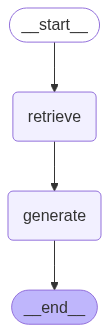

2025-05-26 11:28:17,204 [INFO] HTTP Request: POST https://api.mistral.ai/v1/embeddings "HTTP/1.1 200 OK"
2025-05-26 11:28:18,843 [INFO] HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


De acordo com o texto, as reuniões ordinárias são designadas pelo Reitor, que expedirá uma circular nos termos do artigo correspondente. No entanto, se o Reitor se recusar a convocar a reunião, os conselheiros que a promoverem também podem subscrever a convocação.

Mais especificamente, o § 1º do artigo não especifica quem convoca as reuniões ordinárias, mas o § 2º do artigo 16 diz que "Na hipótese de recusa do Reitor, a convocação poderá ser subscrita pelos conselheiros que a promoverem", o que implica que o Reitor é o responsável por convocar as reuniões.

Portanto, a resposta é: O Reitor.


In [38]:
from typing import TypedDict, List
from langchain.schema import Document
from langgraph.graph import START, StateGraph
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage

# 1. Definição do estado
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# 2. Definição do retriever
retriever = get_retriever(PERSIST_DIR, COLLECTION_NAME, search_kwargs={"k": 3})

# 3. Prompt e LLM
prompt = PromptTemplate(input_variables=["question", "context"], template=
"""Contexto: {context}
Pergunta: {question}
Resposta:""")
# Substitua pelo seu LLM favorito
from langchain_groq import ChatGroq
llm = ChatGroq(model=LLM_MODEL_NAME)

# 4. Passos do fluxo
def retrieve(state: State):
    retrieved_docs = retriever.get_relevant_documents(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    prompt_value = prompt.format(question=state["question"], context=docs_content)
    response = llm.invoke([HumanMessage(content=prompt_value)])
    return {"answer": response.content}

# 5. Construção do grafo
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph = graph_builder.compile()

# 6. Visualizar o fluxo (se estiver num notebook)
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 7. Executando um exemplo
initial_state = {"question": "Quem designa as reuniões ordinarias?", "context": [], "answer": ""}
result = graph.invoke(initial_state)
print(result["answer"])
